# Client side encoding with blocking and server side linking

For this tutorial we are going to encode a data set for private record linkage using the command line tool `anonlink`.

Note you can also directly use the [Python API](./tutorial_api.ipynb).

The Python package `recordlinkage` has a [tutorial](http://recordlinkage.readthedocs.io/en/latest/notebooks/link_two_dataframes.html) linking data sets in the clear, we will try duplicate that in a privacy preserving setting.

First install clkhash, recordlinkage and a few data science tools (pandas and numpy).

In [ ]:
# NBVAL_IGNORE_OUTPUT
!pip install -U anonlink-client recordlinkage numpy pandas metaphone matplotlib

In [11]:
%matplotlib inline
import pandas as pd
import itertools
from clkhash.describe import get_encoding_popcounts
from clkhash.serialization import deserialize_bitarray
import json
import matplotlib.pyplot as plt
from recordlinkage.datasets import load_febrl4

In [4]:
dfA, dfB = load_febrl4()

dfA.head()

,given_name,surname,street_number,address_1,address_2,suburb,postcode,state,date_of_birth,soc_sec_id
rec_id,,,,,,,,,,
rec-1070-org,michaela,neumann,8,stanley street,miami,winston hills,4223,nsw,19151111,5304218
rec-1016-org,courtney,painter,12,pinkerton circuit,bega flats,richlands,4560,vic,19161214,4066625
rec-4405-org,charles,green,38,salkauskas crescent,kela,dapto,4566,nsw,19480930,4365168
rec-1288-org,vanessa,parr,905,macquoid place,broadbridge manor,south grafton,2135,sa,19951119,9239102
rec-3585-org,mikayla,malloney,37,randwick road,avalind,hoppers crossing,4552,vic,19860208,7207688


Note that for computing this linkage we will **not** use the social security id column or the `rec_id` index.

In [5]:
dfA.columns

Index(['given_name', 'surname', 'street_number', 'address_1', 'address_2',
       'suburb', 'postcode', 'state', 'date_of_birth', 'soc_sec_id'],
      dtype='object')

In [6]:
dfA.to_csv('PII_a.csv')

## Hashing Schema Definition

A hashing schema instructs clkhash how to treat each column for generating CLKs. A detailed description of the hashing schema can be found in the [api docs](http://clkhash.readthedocs.io/en/latest/schema.html). We will ignore the columns 'rec_id' and 'soc_sec_id' for CLK generation.



In [7]:
with open("../_static/febrl_schema_v3_overweight.json") as f:
    print(f.read())

{
  "version": 3,
  "clkConfig": {
    "l": 1024,
    "kdf": {
      "type": "HKDF",
      "hash": "SHA256",
        "info": "c2NoZW1hX2V4YW1wbGU=",
        "salt": "SCbL2zHNnmsckfzchsNkZY9XoHk96P/G5nUBrM7ybymlEFsMV6PAeDZCNp3rfNUPCtLDMOGQHG4pCQpfhiHCyA==",
        "keySize": 64
    }
  },
  "features": [
    {
      "identifier": "rec_id",
      "ignored": true
    },
    {
      "identifier": "given_name",
      "format": { "type": "string", "encoding": "utf-8", "maxLength": 64 },
      "hashing": { "comparison": {"type": "ngram", "n": 2}, "strategy": {"bitsPerFeature": 300}, "hash": {"type": "doubleHash"} }
    },
    {
      "identifier": "surname",
      "format": { "type": "string", "encoding": "utf-8", "maxLength": 64 },
      "hashing": { "comparison": {"type": "ngram", "n": 2}, "strategy": {"bitsPerFeature": 300}, "hash": {"type": "doubleHash"} }
    },
    {
      "identifier": "street_number",
      "format": { "type": "integer" },
      "hashing": { "comparison": {"type": "n

## Validate the schema

The command line tool can check that the linkage schema is valid:

In [8]:
!anonlink validate-schema "../_static/febrl_schema_v3_overweight.json"

schema is valid


## Encode the data

We can now encode our Personally Identifiable Information (PII) data from the CSV file using our defined linkage schema. We must provide a *secret key* to this command - this secret has to be used by all parties contributing data. For this toy example we will use the secret `horse staple battery`, for real data, make sure that the secret contains enough entropy, as knowledge of this secret is sufficient to reconstruct the PII information from a CLK! 

Also, **do not share these keys with anyone, except the other participating party.**

In [9]:
# NBVAL_IGNORE_OUTPUT
!anonlink hash "PII_a.csv" "horse staple battery" "../_static/febrl_schema_v3_overweight.json" "clks_a.json" -v

generating CLKs: 100%|█| 5.00k/5.00k [00:03<00:00, 1.45kclk/s, mean=944, std=14.
CLK data written to clks_a.json


## Inspect the output

The PII has now been encoded, anonlink-client has used the `clkhash` library to create a _Cryptographic Longterm Key_ for each entity. The stats output shows that the mean number of bits set is quite high (more than 900 out of 1024) which can effect accuracy.

To fix this, we can reduce the popcount by modifying the  _'strategy'_ for different fields. 

This can be used to de-emphasise columns which are less suitable for linkage (e.g. information that changes frequently).

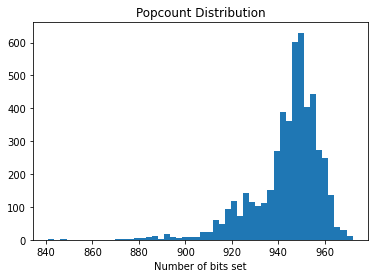

In [13]:
def show_clk_popcounts(filename):
    with open(filename) as f:
        serialized_clks = json.load(f)['clks']
    popcounts = get_encoding_popcounts([deserialize_bitarray(clk) for clk in serialized_clks])

    plt.hist(popcounts, bins=50)
    plt.title("Popcount Distribution")
    plt.xlabel("Number of bits set")

show_clk_popcounts("clks_a.json")

First, we will reduce the value of *bits_per_feature* for each feature.

In [14]:
with open("../_static/febrl_schema_v3_reduced.json") as f:
    print(f.read())

{
  "version": 3,
  "clkConfig": {
    "l": 1024,
    "kdf": {
      "type": "HKDF",
      "hash": "SHA256",
        "info": "c2NoZW1hX2V4YW1wbGU=",
        "salt": "SCbL2zHNnmsckfzchsNkZY9XoHk96P/G5nUBrM7ybymlEFsMV6PAeDZCNp3rfNUPCtLDMOGQHG4pCQpfhiHCyA==",
        "keySize": 64
    }
  },
  "features": [
    {
      "identifier": "rec_id",
      "ignored": true
    },
    {
      "identifier": "given_name",
      "format": { "type": "string", "encoding": "utf-8", "maxLength": 64 },
      "hashing": { "comparison": {"type": "ngram", "n": 2}, "strategy": {"bitsPerFeature": 200}, "hash": {"type": "doubleHash"} }
    },
    {
      "identifier": "surname",
      "format": { "type": "string", "encoding": "utf-8", "maxLength": 64 },
      "hashing": { "comparison": {"type": "ngram", "n": 2}, "strategy": {"bitsPerFeature": 200}, "hash": {"type": "doubleHash"} }
    },
    {
      "identifier": "street_number",
      "format": { "type": "integer" },
      "hashing": { "comparison": {"type": "n

In [15]:
# NBVAL_IGNORE_OUTPUT
!anonlink hash "PII_a.csv" secret "../_static/febrl_schema_v3_reduced.json" "clks_a.json" -v

generating CLKs: 100%|█| 5.00k/5.00k [00:02<00:00, 1.67kclk/s, mean=839, std=20.
CLK data written to clks_a.json


And now we will modify the `bits_per_feature` values again, this time de-emphasising the contribution of the address related columns.

In [16]:
with open("../_static/febrl_schema_v3_final.json") as f:
    print(f.read())

{
  "version": 3,
  "clkConfig": {
    "l": 1024,
    "kdf": {
      "type": "HKDF",
      "hash": "SHA256",
        "info": "c2NoZW1hX2V4YW1wbGU=",
        "salt": "SCbL2zHNnmsckfzchsNkZY9XoHk96P/G5nUBrM7ybymlEFsMV6PAeDZCNp3rfNUPCtLDMOGQHG4pCQpfhiHCyA==",
        "keySize": 64
    }
  },
  "features": [
    {
      "identifier": "rec_id",
      "ignored": true
    },
    {
      "identifier": "given_name",
      "format": { "type": "string", "encoding": "utf-8", "maxLength": 64 },
      "hashing": { "comparison": {"type": "ngram", "n": 2}, "strategy": {"bitsPerFeature": 200}, "hash": {"type": "doubleHash"} }
    },
    {
      "identifier": "surname",
      "format": { "type": "string", "encoding": "utf-8", "maxLength": 64 },
      "hashing": { "comparison": {"type": "ngram", "n": 2}, "strategy": {"bitsPerFeature": 200}, "hash": {"type": "doubleHash"} }
    },
    {
      "identifier": "street_number",
      "format": { "type": "integer" },
      "hashing": { "comparison": {"type": "n

In [17]:
# NBVAL_IGNORE_OUTPUT
!anonlink hash "PII_a.csv" secret "../_static/febrl_schema_v3_final.json" "clks_a.json" -v

generating CLKs: 100%|█| 5.00k/5.00k [00:02<00:00, 2.12kclk/s, mean=696, std=23.
CLK data written to clks_a.json


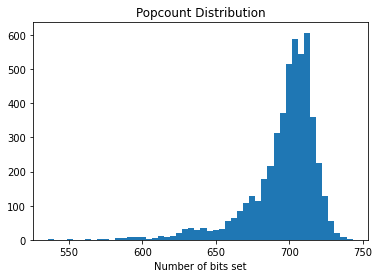

In [18]:
show_clk_popcounts("clks_a.json")

Great, now approximately half the bits are set in each CLK. 

Each CLK is serialized in a JSON friendly base64 format:

## Hash data set B

Now we hash the second dataset using the same keys and same schema.

In [19]:
# NBVAL_IGNORE_OUTPUT
dfB.to_csv("PII_b.csv")

!anonlink hash "PII_b.csv" secret "../_static/febrl_schema_v3_final.json" "clks_b.json" -v

generating CLKs: 100%|█| 5.00k/5.00k [00:02<00:00, 1.88kclk/s, mean=687, std=30.
CLK data written to clks_b.json


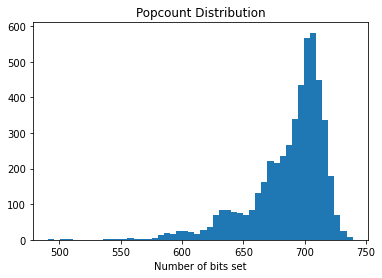

In [20]:
show_clk_popcounts("clks_b.json")

# Blocking



We create a blocking schema to group the encodings into similar blocks on the client side. The central linkage service will then compare all encodings in each block, efficient blocking can drastically reduce the total number of encoding comparisons the central linkage service must carry out.

In [21]:
# NBVAL_IGNORE_OUTPUT
with open("blocking_schema.json", 'wt') as f:
    f.write("""
{
    "type": "lambda-fold",
    "version": 1,
    "config": {
        "blocking-features": [6],
        "Lambda": 3,
        "bf-len": 64,
        "num-hash-funcs": 3,
        "K": 5,
        "input-clks": true,
        "random_state": 0
    }
}    
    """)

In [22]:
# NBVAL_IGNORE_OUTPUT 
!anonlink block 'clks_a.json' 'blocking_schema.json' 'blocks_a.json'

Statistics for the generated blocks:
	Number of Blocks:   96
	Minimum Block Size: 2
	Maximum Block Size: 1152
	Average Block Size: 156.25
	Median Block Size:  85
	Standard Deviation of Block Size:  188.9700616778391


In [23]:
# NBVAL_IGNORE_OUTPUT
!anonlink block 'clks_b.json' 'blocking_schema.json' 'blocks_b.json'

Statistics for the generated blocks:
	Number of Blocks:   96
	Minimum Block Size: 3
	Maximum Block Size: 1108
	Average Block Size: 156.25
	Median Block Size:  86
	Standard Deviation of Block Size:  181.9370625706651


Various blocking statistics are printed out to help with refining the blocking schema. The record linkage run time will be largely dominated by the maximum block size, and the number of blocks. In general the smaller the average block size, the better.

## Find matches between the two sets of CLKs

We have generated two sets of blocked CLKs which represent individual entitys in a privacy-preserving way. The more similar the bits in two CLKs are, the more likely it is that they represent the same entity.

To compare the similarity between the bits we will use the anonlink entity service, which is provided by Data61. 

The necessary steps are as follows:

- The analyst creates a new project. They will receive a set of credentials from the server.
- The analyst then distributes the `update_tokens` to the participating data providers.
- The data providers then individually upload their respective encodings.
- The analyst can create *runs* with various thresholds (and other settings)
- After the entity service successfully computed the mapping, it can be accessed by providing the `result_token`

First we check the status of an entity service:

In [25]:
# NBVAL_IGNORE_OUTPUT
SERVER = 'https://anonlink.easd.data61.xyz'
!anonlink status --server={SERVER}

{"project_count": 1554, "rate": 521702, "status": "ok"}


The analyst creates a new project on the entity service by providing the hashing schema and result type. The server returns a set of credentials which provide access to the further steps for project.

In [26]:
# NBVAL_IGNORE_OUTPUT
!anonlink create-project --server={SERVER} --schema "../_static/febrl_schema_v3_final.json" --output "credentials.json" --type "groups" --name "Blocking Test" --blocked

Project created


The returned credentials contain a 
- `project_id`, which identifies the project
- `result_token`, which gives access to the result, once computed
- `upload_tokens`, one for each provider, allows uploading CLKs.

The returned credentials contain a 
- `project_id`, which identifies the project
- `result_token`, which gives access to the result, once computed
- `upload_tokens`, one for each provider, allows uploading CLKs.

In [27]:
# NBVAL_IGNORE_OUTPUT
credentials = json.load(open("credentials.json", 'rt'))
print(json.dumps(credentials, indent=4))

{
    "project_id": "c23150a3d79b8abc7f6af32e50fa3f99a78cb87bc306063e",
    "result_token": "3e93c3bcb29c48c70fafbd4f8b6f50826baab3cb9b01a6e9",
    "update_tokens": [
        "bbadf1cf836438c013fda6c320fa1d394bd0d54ba8c7478b",
        "a36fa5b5f2ec5d92bd0676adf3022ab255914dc126df42e9"
    ]
}


### Uploading the CLKs to the entity service
Each party individually uploads its respective CLKs to the entity service. They need to provide the `project_id`, which identifies the correct results, and an `update_token`.

By default, data is uploaded to object store since it has more reliable uploading mechanism especially with large size datasets. You can also specify to upload to entity service directly by adding a flag `--to_entityservice` to command `upload`. A message will be printed to tell users if the encodings and blocks are uploaded to object store:

```
Anonlink client: Uploading to the external object store - MINIO
```
or they are uploaded to entity service:
```
Anonlink client: Uploading to entity service
```

Note that the progress bar is only available when uploading to object store. Uploading to entity service is performed with `requests` which does not support streaming upload yet.

In [28]:
# NBVAL_IGNORE_OUTPUT
!anonlink upload \
       --project="{credentials['project_id']}" \
        --apikey="{credentials['update_tokens'][0]}" \
        --output "upload_a.json" \
        --server="{SERVER}" \
        --blocks="blocks_a.json" \
        "clks_a.json"

uploads
Anonlink client: Uploading to the external object store - MINIO
Upload blocks_a.json: |####################| 0.45 MB/0.45 MB 100% [elapsed: 00:00 left: 00:00,  1.56 MB/sec]

In [29]:
# NBVAL_IGNORE_OUTPUT
!anonlink upload \
       --project="{credentials['project_id']}" \
        --apikey="{credentials['update_tokens'][1]}" \
        --output "upload_b.json" \
        --server="{SERVER}" \
        --blocks="blocks_b.json" \
        "clks_b.json"

uploads
Anonlink client: Uploading to the external object store - MINIO
Upload blocks_b.json: |####################| 0.45 MB/0.45 MB 100% [elapsed: 00:00 left: 00:00,  1.76 MB/sec]

Now that the CLK data has been uploaded the analyst can create one or more *runs*. Here we will start by calculating a mapping with a threshold of `0.9`:

In [30]:
# NBVAL_IGNORE_OUTPUT
!anonlink create --verbose  \
    --server="{SERVER}" \
    --output "run_info.json" \
    --threshold=0.9 \
    --project="{credentials['project_id']}" \
    --apikey="{credentials['result_token']}" \
    --name="Blocked run"

Connecting to Entity Matching Server: https://anonlink.easd.data61.xyz


In [31]:
# NBVAL_IGNORE_OUTPUT
run_info = json.load(open("run_info.json", 'rt'))
run_info

{'name': 'Blocked run',
 'notes': 'Run created by anonlink-client 0.1.4b0',
 'run_id': '3a294af61ba6123734eefae00781706158edcd58e08883fd',
 'threshold': 0.9}

## Results

Now after some delay (depending on the size) we can fetch the results. This can be done with anonlink:

In [32]:
# NBVAL_IGNORE_OUTPUT
!anonlink results --watch \
        --project="{credentials['project_id']}" \
        --apikey="{credentials['result_token']}" \
        --run="{run_info['run_id']}" \
        --server="{SERVER}" \
        --output results.txt

State: completed
Stage (3/3): compute output
State: completed
Stage (3/3): compute output
State: completed
Stage (3/3): compute output
Received result


In [33]:
# NBVAL_IGNORE_OUTPUT
def extract_matches(file):
    with open(file, 'rt') as f:
        results = json.load(f)['groups']
    # each entry in `results` looks like this: '((0, 4039), (1, 2689))'.
    # The format is ((dataset_id, row_id), (dataset_id, row_id))
    # As we only have two parties in this example, we can remove the dataset_ids.
    # Also, turning the solution into a set will make it easier to assess the
    # quality of the matching.
    found_matches = set((a, b) for ((_, a), (_, b)) in results)
    print('The service linked {} entities.'.format(len(found_matches)))
    return found_matches

found_matches = extract_matches('results.txt')

The service linked 3941 entities.


Let's investigate some of those matches and the overall matching quality. In this case we have the ground truth so we can compute the precision and recall.

Fortunately, the febrl4 datasets contain record ids which tell us the correct linkages. Using this information we are able to create a set of the true matches.

In [34]:
# rec_id in dfA has the form 'rec-1070-org'. We only want the number. Additionally, as we are 
# interested in the position of the records, we create a new index which contains the row numbers.
dfA_ = dfA.rename(lambda x: x[4:-4], axis='index').reset_index()
dfB_ = dfB.rename(lambda x: x[4:-6], axis='index').reset_index()
# now we can merge dfA_ and dfB_ on the record_id.
a = pd.DataFrame({'ida': dfA_.index, 'rec_id': dfA_['rec_id']})
b = pd.DataFrame({'idb': dfB_.index, 'rec_id': dfB_['rec_id']})
dfj = a.merge(b, on='rec_id', how='inner').drop(columns=['rec_id'])
# and build a set of the corresponding row numbers.
true_matches = set((row[0], row[1]) for row in dfj.itertuples(index=False))

In [35]:
def describe_matching_quality(found_matches, show_examples=False):
    if show_examples:
        print('idx_a, idx_b,     rec_id_a,       rec_id_b')
        print('---------------------------------------------')
        for a_i, b_i in itertools.islice(found_matches, 10):
            print('{:3}, {:6}, {:>15}, {:>15}'.format(a_i+1, b_i+1, a.iloc[a_i]['rec_id'], b.iloc[b_i]['rec_id']))
        print('---------------------------------------------')
    
    tp = len(found_matches & true_matches)
    fp = len(found_matches - true_matches)
    fn = len(true_matches - found_matches)

    precision = tp / (tp + fp)
    recall = tp / (tp + fn)


    print('Precision: {:.2f}, Recall: {:.2f}'.format(precision, recall))

In [36]:
# NBVAL_IGNORE_OUTPUT
describe_matching_quality(found_matches, True)

idx_a, idx_b,     rec_id_a,       rec_id_b
---------------------------------------------
3170,    259,            3730,            3730
733,   2003,            4239,            4239
1685,   3323,            2888,            2888
4550,   3627,            4216,            4216
1875,   2991,            4391,            4391
3928,   2377,            3493,            3493
4928,   4656,             276,             276
2288,   4331,            3491,            3491
334,    945,            4848,            4848
4088,   2454,            1850,            1850
---------------------------------------------
Precision: 1.00, Recall: 0.79


Precision tells us about how many of the found matches are actual matches, and recall tells us how many of the actual matches we found.

We may have to change how we encode or block the data, but first let's create another run with a lower `threshold` value.

In [37]:
# NBVAL_IGNORE_OUTPUT
!anonlink create --verbose  \
    --server="{SERVER}" \
    --output "run_info.json" \
    --threshold=0.8 \
    --project="{credentials['project_id']}" \
    --apikey="{credentials['result_token']}" \
    --name="Another blocked run"

run_info = json.load(open('run_info.json', 'rt'))

Connecting to Entity Matching Server: https://anonlink.easd.data61.xyz


In [38]:
# NBVAL_IGNORE_OUTPUT
!anonlink results --watch \
        --project="{credentials['project_id']}" \
        --apikey="{credentials['result_token']}" \
        --run="{run_info['run_id']}" \
        --server="{SERVER}" \
        --output results.txt

State: running
Stage (3/3): compute output
State: running
Stage (3/3): compute output
State: completed
Stage (3/3): compute output
Received result


In [39]:
with open("results.txt", 'rt') as f:
    results = json.load(f)['groups']
    
found_matches = extract_matches('results.txt')
describe_matching_quality(found_matches)

The service linked 4586 entities.
Precision: 1.00, Recall: 0.92


Great, for this lower threshold value we get a higher precision.

The explanation is that when the information about an entity differs slightly in the two datasets (e.g. spelling errors, abbrevations, missing values, ...) then the corresponding CLKs will differ in some number of bits as well.

It is important to choose an appropriate threshold for the amount of perturbations present in the data.

Feel free to go back to the encoding and blocking and experiment on how different setting will affect the matching quality.

## P-Sig Blocking

Here we can try a different blocking technique - probability signature blocking.

In [43]:
with open("psig_blocking_schema.json") as f:
    print(f.read())

{
        "type": "p-sig",
        "version": 1,
        "config": {
            "blocking-features": [1, 2, 3, 4, 5, 6, 7],
            "filter": {
                "type": "count",
                "max": 100,
                "min": 0.00
            },
            "blocking-filter": {
                "type": "bloom filter",
                "number-hash-functions": 4,
                "bf-len": 2048
            },
            "signatureSpecs": [
                [
                    {"type": "characters-at", "config": {"pos": ["0"]}, "feature-idx": 1},
                    {"type": "characters-at", "config": {"pos": ["0"]}, "feature-idx": 2}
                ],
                [
                    {"type": "characters-at", "config": {"pos": ["0:"]}, "feature-idx": 7}
                ],
                [
                    {"type": "characters-at", "config": {"pos": ["0:"]}, "feature-idx": 4}
                ],
                [
                    {"type": "characters-at", "config": {"po

In [44]:
# NBVAL_IGNORE_OUTPUT 
!anonlink block 'PII_a.csv' 'psig_blocking_schema.json' 'psig_blocks_a.json'

P-Sig: 100.0% records are covered in blocks
Statistics for the generated blocks:
	Number of Blocks:   24640
	Minimum Block Size: 1
	Maximum Block Size: 15
	Average Block Size: 1.2175324675324675
	Median Block Size:  1
	Standard Deviation of Block Size:  0.9897405036787084


In [45]:
# NBVAL_IGNORE_OUTPUT 
!anonlink block 'PII_b.csv' 'psig_blocking_schema.json' 'psig_blocks_b.json'

P-Sig: 100.0% records are covered in blocks
Statistics for the generated blocks:
	Number of Blocks:   24650
	Minimum Block Size: 1
	Maximum Block Size: 15
	Average Block Size: 1.2170385395537526
	Median Block Size:  1
	Standard Deviation of Block Size:  0.9891874327374874


In [46]:
# NBVAL_IGNORE_OUTPUT 
!anonlink create-project --server={SERVER} --schema "../_static/febrl_schema_v3_final.json" --output "credentials.json" --type "groups" --name "Blocking Test" --blocked

Project created


In [47]:
# NBVAL_IGNORE_OUTPUT
credentials = json.load(open("credentials.json", 'rt'))
print(json.dumps(credentials, indent=4))

{
    "project_id": "2c50410532dca33b9415a98078302b8b04b37024b6186bac",
    "result_token": "c2a53a2442ea40dd0863bf1a45213803ca58e70422817ff7",
    "update_tokens": [
        "2c0b3cf1275b085fdf0991430934e58cd92e61b389ee2a2a",
        "c405aa7cb58cc2461e500e188da43bfbd2bd6a58e532a754"
    ]
}


In [48]:
# NBVAL_IGNORE_OUTPUT
!anonlink upload \
       --project="{credentials['project_id']}" \
        --apikey="{credentials['update_tokens'][0]}" \
        --output "upload_a.json" \
        --server="{SERVER}" \
        --blocks="psig_blocks_a.json" \
        "clks_a.json"

uploads
Anonlink client: Uploading to the external object store - MINIO
Upload psig_blocks_a.json: |####################| 1.24 MB/1.24 MB 100% [elapsed: 00:00 left: 00:00,  1.93 MB/sec]

In [49]:
# NBVAL_IGNORE_OUTPUT
!anonlink upload \
       --project="{credentials['project_id']}" \
        --apikey="{credentials['update_tokens'][1]}" \
        --output "upload_b.json" \
        --server="{SERVER}" \
        --blocks="psig_blocks_b.json" \
        "clks_b.json"

uploads
Anonlink client: Uploading to the external object store - MINIO
Upload psig_blocks_b.json: |####################| 1.24 MB/1.24 MB 100% [elapsed: 00:00 left: 00:00,  2.00 MB/sec]

In [50]:
# NBVAL_IGNORE_OUTPUT
!anonlink create --verbose  \
    --server="{SERVER}" \
    --output "run_info.json" \
    --threshold=0.8 \
    --project="{credentials['project_id']}" \
    --apikey="{credentials['result_token']}" \
    --name="Psig Blocked run"

Connecting to Entity Matching Server: https://anonlink.easd.data61.xyz


In [51]:
# NBVAL_IGNORE_OUTPUT
run_info = json.load(open("run_info.json", 'rt'))
run_info

{'name': 'Psig Blocked run',
 'notes': 'Run created by anonlink-client 0.1.4b0',
 'run_id': '7e090fc37a00dbb54d47babb65921af8d0053d189ada1d23',
 'threshold': 0.8}

In [52]:
# NBVAL_IGNORE_OUTPUT
!anonlink results --watch \
        --project="{credentials['project_id']}" \
        --apikey="{credentials['result_token']}" \
        --run="{run_info['run_id']}" \
        --server="{SERVER}" \
        --output psig_results.txt

State: created
Stage (1/3): waiting for CLKs
Progress: 0.00%
State: created
Stage (1/3): waiting for CLKs
Progress: 0.00%
State: created
Stage (1/3): waiting for CLKs
Progress: 50.00%
State: running
Stage (2/3): compute similarity scores
State: running
Stage (2/3): compute similarity scores
Progress: 100.00%
State: running
Stage (3/3): compute output
State: completed
Stage (3/3): compute output
Received result


In [53]:
found_matches = extract_matches('psig_results.txt')
describe_matching_quality(found_matches)

The service linked 4752 entities.
Precision: 1.00, Recall: 0.95


## Cleanup

Finally to remove the results from the service delete the individual runs, or remove the uploaded data and all runs by deleting the entire project.

In [54]:
# NBVAL_IGNORE_OUTPUT
# Deleting a run
!anonlink delete --project="{credentials['project_id']}" \
        --apikey="{credentials['result_token']}" \
        --run="{run_info['run_id']}" \
        --server="{SERVER}"

Run deleted


In [55]:
# NBVAL_IGNORE_OUTPUT
# Deleting a project
!anonlink delete-project --project="{credentials['project_id']}" \
        --apikey="{credentials['result_token']}" \
        --server="{SERVER}"

Project deleted
